This lab on Linear Regression is a python adaptation of p. 110-120 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. 
It is based on the work of R. Jordan Crouser at Smith College for SDS293: Machine Learning (Spring 2016).

# Warmup exercises


## 1.

Suppose we have a data set with five predictors, $$\begin{aligned}
    X_1 &= \text{GPA},\\
    X_2 &= \text{IQ},\\
    X_3 &= \text{Level},\quad \text{1 for College and 0 for High
          School},\\
    X_4 &= \text{Interaction between GPA and IQ}, \\
    X_5 &= \text{Interaction between GPA and Level}. 
  \end{aligned}$$ The response is starting salary after graduation (in
thousands of dollars). Suppose we use least squares to fit the model,
and get $\hat\beta_0 = 50$, $\hat \beta_1 = 20$, $\hat\beta_2 = 0.07$,
$\hat\beta_3 = 35$, $\hat\beta_4 = 0.01$, $\hat\beta_5 = -10$.

a. Which answer is correct, and why?

   -   For a fixed value of IQ and GPA, high school graduates earn
        more, on average, than college graduates.

   -   For a fixed value of IQ and GPA, college graduates earn more, on
        average, than high school graduates.

   -   For a fixed value of IQ and GPA, high school graduates earn
        more, on average, than college graduates provided that the GPA
        is high enough.

   -   For a fixed value of IQ and GPA, college graduates earn more, on
        average, than high school graduates provided that the GPA is
        high enough.

    

b.  Predict the salary of a college graduate with IQ of 110 and a GPA of
    4.0.


In [ ]:
beta = np.array([50, 20 , 0.07, 35, 0.01, -10])


c.  True or false: Since the coefficient for the GPA/IQ interaction term
    is very small, there is very little evidence of an interaction
    effect. Justify your answer.

## 2.

This exercise relates to the College data set, which can be found in the
file [`College.csv`](https://www.statlearning.com/s/College.csv) on the
ISL book website. It contains a number of variables for 777 different
universities and colleges in the US. The variables are

-   `Private` : Public/private indicator

-   `Apps` : Number of applications received

-   `Accept` : Number of applicants accepted

-   `Enroll` : Number of students enrolled

-   `Top10perc` : New students from top 10 % of high school class

-   `Top25perc` : New students from top 25 % of high school class

-   `F.Undergrad` : Number of full-time undergraduates

-   `P.Undergrad` : Number of part-time undergraduates

-   `Outstate` : Out-of-state tuition

-   `Room.Board` : Room and board costs

-   `Books` : Estimated book costs

-   `Personal` : Estimated personal spending

-   `PhD` : Percent of faculty with Ph.D.'s

-   `Terminal` : Percent of faculty with terminal degree

-   `S.F.Ratio` : Student/faculty ratio

-   `perc.alumni` : Percent of alumni who donate

-   `Expend` : Instructional expenditure per student

-   `Grad.Rate` : Graduation rate

a.  Use the `pd.read_csv` function to load the data. Call the loaded
    data `college`, for example

        import urllib
        url = "https://www.statlearning.com/s/College.csv"
        with urllib.request.urlopen(url) as f:
          college = pd.read_csv(f, index_col=0)

    


In [ ]:
import pandas as pd

url = "https://www.statlearning.com/s/College.csv"

college = pd.read_csv(url, index_col=0)



# 3.6.1 Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Tells matplotlib to display images inline instead of a new window
%matplotlib inline
import statsmodels.api as sm

We'll start by importing the data from [Boston.csv](http://www.science.smith.edu/~jcrouser/SDS293/data/Boston.csv) into a pandas dataframe:

In [2]:
from_smith_edu = False # or True 

if not from_smith_edu:
    from sklearn.datasets import load_boston
    ds = load_boston()
    colnames = [line.split()[1].lower() for line in ds['DESCR'].split('\n') if "    -" in line]
    vars = np.concatenate([ds.data, ds.target[:,None]], axis=-1)
    df = pd.DataFrame(vars, columns=colnames)
    df.__doc__=ds['DESCR']
else:
    ## alternatively we could use this:
    url = 'https://www.science.smith.edu/~jcrouser/SDS293/data/Boston.csv'
    df = pd.read_csv(url, index_col=0)

print(df.head())
print(df.describe())

      crim    zn  indus  chas    nox     rm   age     dis  rad    tax  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   ptratio       b  lstat  medv  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  
             crim          zn       indus        chas         nox          rm  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    

/home/prokaj/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets incl

In [3]:
print(df.__doc__)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

# 3.6.2 Simple Linear Regression

Now let's fit a simple linear model (`OLS` - for "ordinary least squares" method) with `medv` as the response and `lstat` as the predictor:

In [4]:
lm = sm.OLS.from_formula('medv ~ lstat', df)
result = lm.fit()

To get detailed information about the model, we can print the results of a call to the `.summary()` method:

In [5]:
print(result.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           5.08e-88
Time:                        18:26:54   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.0

Want individual attributes? You can access them independently like this:

In [6]:
result.rsquared, result.fvalue, result.params.Intercept, result.params.lstat

(0.5441462975864799, 601.6178711098955, 34.55384087938308, -0.9500493537579922)

For a complete list of attributes and methods of a `RegressionResults` object, see: http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.RegressionResults.html?highlight=regressionresults

For quick help use:

In [7]:
result?

Type:            RegressionResultsWrapper
String form:     <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f6295de8af0>
File:            ~/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/statsmodels/regression/linear_model.py
Docstring:      
Results class for for an OLS model.

Parameters
----------
model : RegressionModel
    The regression model instance.
params : ndarray
    The estimated parameters.
normalized_cov_params : ndarray
    The normalized covariance parameters.
scale : float
    The estimated scale of the residuals.
cov_type : str
    The covariance estimator used in the results.
cov_kwds : dict
    Additional keywords used in the covariance specification.
use_t : bool
    Flag indicating to use the Student's t in inference.
**kwargs
    Additional keyword arguments used to initialize the results.

See Also
--------
RegressionResults
    Results store for WLS and GLW models.

Notes
-----
Most of the methods and attributes ar

Now let's try making some predictions using this model. First, we'll set up a dataframe containing the `lstat` values for which we want to predict a response:

In [8]:
new = pd.DataFrame([[1, 5], [1, 10], [1, 15]], columns=['Intercept', 'lstat'])

Now we just call the `.predict()` method:

In [9]:
result.predict(new)

0    29.803594
1    25.053347
2    20.303101
dtype: float64

Technically those are the right prediction values, but maybe it would be good to have the confidence intervals along with them. Let's write a little helper function to get that and package it all up:

In [10]:
Sigma=result.cov_params()
(new.dot(Sigma)*new).sum(axis=1)

0    0.164225
1    0.086915
2    0.084619
dtype: float64

In [11]:
result.cov_params()

,Intercept,lstat
Intercept,0.316550,-0.018983
lstat,-0.018983,0.001500


The covariance of the `intercept` term and the `lstat` coefficient is negative. Student-t distribution is in the `scipy.stats` module.

In [12]:
from  scipy.stats import t as student_t
def predict(res, new, alpha=0.05):
    fit = pd.DataFrame(res.predict(new), columns=['fit'])
    # the variance of the predicted value is <new Sigma, new> (new is a row vector).
    sigma = (new.dot(res.cov_params())*new).sum(axis=1)**0.5
    # isf is the inverse survival function, 
    # that is the inverse of 1-F, where F is the distribution function
    t = student_t(df=res.df_resid, scale=sigma).isf(alpha/2)
    fit['lower'] = fit.fit-t
    fit['upper'] = fit.fit+t
    return fit
    

This is a confidence in the expected value of the response (the value of the regression function). Since new observations at these levels of `lstat` also contains the noise term, the confidence intervals for the new observed response values are much higher. 

In [13]:
def predict(res, new, interval='confidence', alpha=0.05):
    fit = pd.DataFrame(res.predict(new), columns=['fit'])
    sigma2 = (new.dot(res.cov_params())*new).sum(axis=1)
    if interval=='prediction':
        sigma2 += res.scale
    sigma = sigma2**.5
    t = student_t(df=res.df_resid, scale=sigma).isf(alpha/2)
    fit['lower'] = fit.fit-t
    fit['upper'] = fit.fit+t
    return fit

In [14]:
print(predict(result, new)) 
print(predict(result, new, interval='prediction')) 

         fit      lower      upper
0  29.803594  29.007412  30.599776
1  25.053347  24.474132  25.632563
2  20.303101  19.731588  20.874613
         fit      lower      upper
0  29.803594  17.565675  42.041513
1  25.053347  12.827626  37.279068
2  20.303101   8.077742  32.528459


Seaborn is a Python visualization library based on matplotlib that provides a high-level interface for drawing attractive statistical graphics.

In [15]:
import seaborn as sns

We will now plot `medv` and `lstat` along with the least squares regression line using the `regplot()` function. We can define the color of the fit line using `line_kws` ("line keywords"):

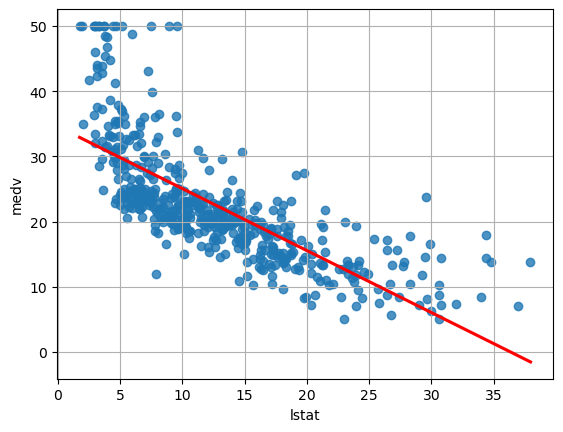

In [16]:
sns.regplot(x='lstat', y='medv', data=df, line_kws = {"color": "r"}, ci=None)
plt.grid()
plt.show()

We can also plot the residuals against the fitted values:

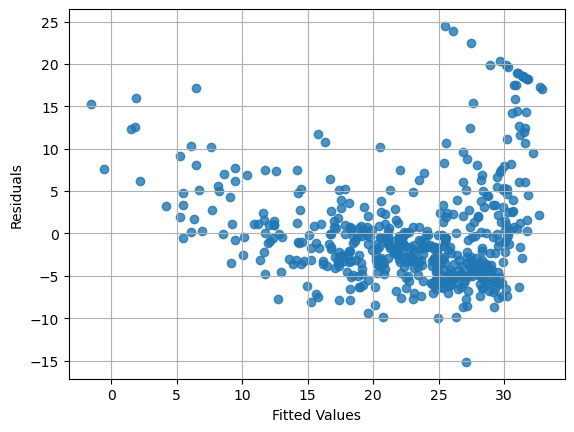

In [17]:
fitted_values = pd.Series(result.fittedvalues, name="Fitted Values")
residuals = pd.Series(result.resid, name="Residuals")
sns.regplot(x=fitted_values, y=residuals, fit_reg=False)
plt.grid()
plt.show()

Perhaps we want studentized residuals instead? (This is almost the same as the residuals normalized to have unit norm, the latter is available as `.resid_pearson`)

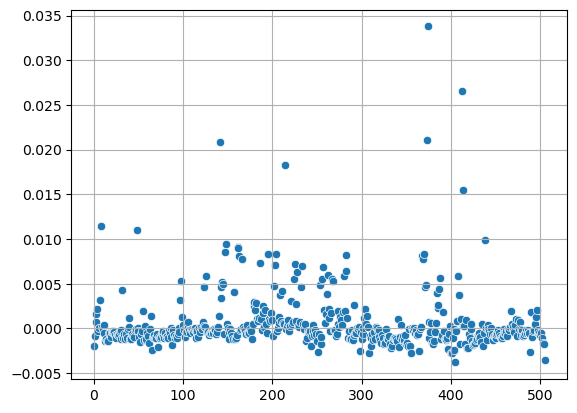

In [18]:
sns.scatterplot(x=np.arange(result.nobs), 
                y=result.get_influence().resid_studentized-result.resid_pearson)
plt.grid()
plt.show()

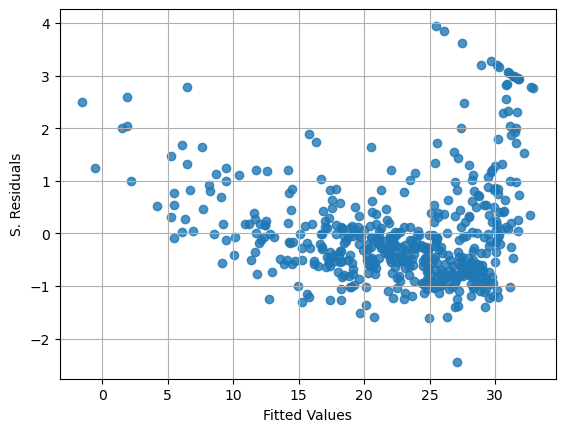

In [19]:
s_residuals = pd.Series(result.get_influence().resid_studentized , name="S. Residuals")
sns.regplot(x=fitted_values, y=s_residuals,  fit_reg=False)
plt.grid()
plt.show()

We can also look for points with high leverage:

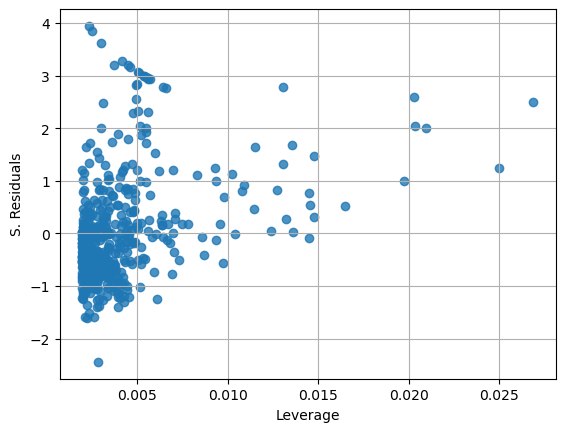

In [20]:
from statsmodels.stats.outliers_influence import OLSInfluence
leverage = pd.Series(OLSInfluence(result).hat_matrix_diag, name = "Leverage")
sns.regplot(x=leverage, y=s_residuals,  fit_reg=False)
plt.grid()
plt.show()

#  3.6.3 Multiple Linear Regression

In order to fit a multiple linear regression model using least squares, we again use the `from_formula()` function. The syntax `from_formula(y∼x1+x2+x3)` is used to fit a model with three predictors, `x1`, `x2`, and `x3`. The `summary()` function now outputs the regression coefficients for all the predictors.

In [21]:
model = sm.OLS.from_formula('medv ~ lstat + age', df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           2.98e-88
Time:                        18:29:54   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.2228      0.731     45.458      0.0

The Boston data set contains 13 variables, and so it would be cumbersome to have to type all of these in order to perform a regression using all of the predictors. Instead, we can use the following short-hand:

In [22]:
# All columns (except medv, which is our response)
model = sm.OLS.from_formula('medv ~ ' + '+'.join(df.columns.difference(['medv'])), df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Thu, 03 Nov 2022   Prob (F-statistic):          6.72e-135
Time:                        18:29:58   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.0

Note that we used the syntax `.join(df.columns.difference(['medv']))` to exclude the response variable above. We can use the same napproach to perform a regression using just a subset of the predictors? For example, in the above regression output, `age` and `indus` have a high p-value. So we may wish to run a regression excluding these predictors:

In [23]:
# All columns (except medv age and indus)
model = sm.OLS.from_formula('medv ~ ' + '+'.join(df.columns.difference(['medv', 'age', 'indus'])), df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     128.2
Date:                Thu, 03 Nov 2022   Prob (F-statistic):          5.54e-137
Time:                        18:30:04   Log-Likelihood:                -1498.9
No. Observations:                 506   AIC:                             3022.
Df Residuals:                     494   BIC:                             3072.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.3411      5.067      7.171      0.0

# 3.6.4 Interaction Terms

It is easy to include interaction terms in a linear model using the `.from_formula()` function. The syntax `lstat:black` tells Python to include an interaction term between `lstat` and `black`. The syntax `lstat*age` simultaneously includes `lstat`, `age`, and the interaction term `lstat*age` as predictors; it is a shorthand for `lstat+age+lstat:age`.

In [24]:
print(sm.OLS.from_formula('medv ~ lstat*age', df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     209.3
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           4.86e-88
Time:                        18:30:19   Log-Likelihood:                -1635.0
No. Observations:                 506   AIC:                             3278.
Df Residuals:                     502   BIC:                             3295.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.0885      1.470     24.553      0.0

# 3.6.5 Non-linear Transformations of the Predictors

The `.from_formula()` function can also accommodate non-linear transformations of the predictors. For instance, given a predictor `X`, we can create a predictor `X^2` using `np.square(X)`. We now perform a regression of `medv` onto `lstat` and `lstat^2`.

In [25]:
lm.fit2 = sm.OLS.from_formula('medv ~ lstat + np.square(lstat)', df).fit()
print(lm.fit2.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Thu, 03 Nov 2022   Prob (F-statistic):          1.56e-112
Time:                        18:30:25   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           42.8620      0.872  

The near-zero p-value associated with the quadratic term suggests that it leads to an improved model. We use the `anova_lm()` function to further quantify the extent to which the quadratic fit is superior to the linear fit.

In [26]:
lm.fit = sm.OLS.from_formula('medv ~ lstat', df).fit()
print(sm.stats.anova_lm(lm.fit, lm.fit2))

   df_resid           ssr  df_diff     ss_diff           F        Pr(>F)
0     504.0  19472.381418      0.0         NaN         NaN           NaN
1     503.0  15347.243158      1.0  4125.13826  135.199822  7.630116e-28


Here Model 0 represents the linear submodel containing only one predictor, `lstat`, while Model 1 corresponds to the larger quadraticmodel that has two predictors, `lstat` and `lstat2`. The `anova_lm()` function performs a hypothesis test comparing the two models. The null hypothesis is that the two models fit the data equally well, and the alternative hypothesis is that the full model is superior. 

The F-statistic is 135 and the associated p-value is virtually zero. This provides very clear evidence that the model containing the predictors `lstat` and `lstat2` is far superior to the model that only contains the predictor `lstat`. This is not surprising, since earlier we saw evidence for non-linearity in the relationship between `medv` and `lstat`. 

If we type:

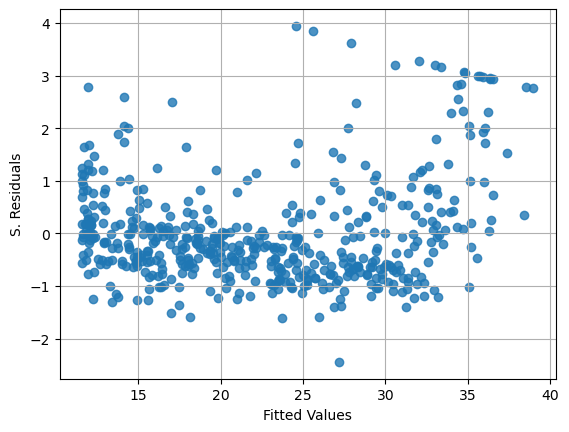

In [27]:
fitted_values = pd.Series(lm.fit2.fittedvalues, name="Fitted Values")
residuals = pd.Series(lm.fit2.get_influence().resid_studentized, name="S. Residuals")
sns.regplot(x=fitted_values, y=s_residuals,  fit_reg=False)
plt.grid()
plt.show()

then we see that when the `lstat2` term is included in the model, there is little discernible pattern in the residuals.

In order to create a cubic fit, we can include a predictor of the form `np.power(x, 3))`. However, this approach can start to get cumbersome for higher order polynomials. A better approach involves using list comprehension inside a `.join()`. For example, the following command produces a fifth-order polynomial fit:

In [28]:
formula_5 = 'medv ~ ' + '+'.join(['np.power(lstat,' + str(i) + ')' for i in range(1,6)])
print(formula_5)
print(sm.OLS.from_formula(formula_5, df).fit().summary())

medv ~ np.power(lstat,1)+np.power(lstat,2)+np.power(lstat,3)+np.power(lstat,4)+np.power(lstat,5)
                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     214.2
Date:                Thu, 03 Nov 2022   Prob (F-statistic):          8.73e-122
Time:                        18:31:04   Log-Likelihood:                -1550.6
No. Observations:                 506   AIC:                             3113.
Df Residuals:                     500   BIC:                             3139.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

Of course, we are in no way restricted to using polynomial transformations of the predictors. Here we try a log transformation.

In [29]:
print(sm.OLS.from_formula('medv ~ np.log(rm)', df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     389.3
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.22e-64
Time:                        18:31:15   Log-Likelihood:                -1695.4
No. Observations:                 506   AIC:                             3395.
Df Residuals:                     504   BIC:                             3403.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -76.4878      5.028    -15.213      0.0

# 3.6.6 Qualitative Predictors

We will now examine the [`Carseats`](http://www.science.smith.edu/~jcrouser/SDS293/data/Carseats.csv) data that we talked about earlier in class. We will attempt to predict `Sales` (child car seat sales) in 400 locations based on a number of predictors.

In [30]:
if from_smith_edu:
    df2 = pd.read_csv('Carseats.csv')
else:
    import statsmodels.datasets as smd
    df2 = smd.get_rdataset('Carseats', 'ISLR')
    df2.data.__doc__= df2.__doc__
    df2 = df2.data
df2.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [31]:
print(df2.__doc__)

.. container::

   ======== ===============
   Carseats R Documentation
   ======== ===============

   .. rubric:: Sales of Child Car Seats
      :name: sales-of-child-car-seats

   .. rubric:: Description
      :name: description

   A simulated data set containing sales of child car seats at 400
   different stores.

   .. rubric:: Usage
      :name: usage

   ::

      Carseats

   .. rubric:: Format
      :name: format

   A data frame with 400 observations on the following 11 variables.

   ``Sales``
      Unit sales (in thousands) at each location

   ``CompPrice``
      Price charged by competitor at each location

   ``Income``
      Community income level (in thousands of dollars)

   ``Advertising``
      Local advertising budget for company at each location (in
      thousands of dollars)

   ``Population``
      Population size in region (in thousands)

   ``Price``
      Price company charges for car seats at each site

   ``ShelveLoc``
      A factor with levels ``Bad``,

The `Carseats` data includes qualitative predictors such as `Shelveloc`, an indicator of the quality of the shelving location—that is, the space within a store in which the car seat is displayed—at each location. The predictor `Shelveloc` takes on three possible values, `Bad`, `Medium`, and `Good`.

Given a qualitative variable such as `Shelveloc`, Python generates dummy variables automatically. Below we fit a multiple regression model that includes some interaction terms.

In [32]:
formula_carseat = 'Sales ~ Income:Advertising+Price:Age + ' + " + ".join(df2.columns.difference(['Sales']))
print(formula_carseat)
print(sm.OLS.from_formula(formula_carseat, df2).fit().summary())

Sales ~ Income:Advertising+Price:Age + Advertising + Age + CompPrice + Education + Income + Population + Price + ShelveLoc + US + Urban
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     210.0
Date:                Thu, 03 Nov 2022   Prob (F-statistic):          6.14e-166
Time:                        18:31:37   Log-Likelihood:                -564.67
No. Observations:                 400   AIC:                             1157.
Df Residuals:                     386   BIC:                             1213.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.02

To learn how to set other coding schemes (or _contrasts_), see: http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/contrasts.html